# 1. Setup Environment

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn joblib


Defaulting to user installation because normal site-packages is not writeable


# 2. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score



# 3. Load Dataset

In [3]:
df = pd.read_csv("unicorns.csv")
print(df.shape)
df.head()

(1186, 7)


,Company,Valuation ($B),Date Joined,Country,City,Industry,Investors
0,ByteDance,$140,4/7/2017,China,Beijing,Artificial intelligence,"Sequoia Capital China, SIG Asia Investments, S..."
1,SpaceX,$127,12/1/2012,United States,Hawthorne,Other,"Founders Fund, Draper Fisher Jurvetson, Rothen..."
2,SHEIN,$100,7/3/2018,China,Shenzhen,E-commerce & direct-to-consumer,"Tiger Global Management, Sequoia Capital China..."
3,Stripe,$95,1/23/2014,United States,San Francisco,Fintech,"Khosla Ventures, LowercaseCapital, capitalG"
4,Canva,$40,1/8/2018,Australia,Surry Hills,Internet software & services,"Sequoia Capital China, Blackbird Ventures, Mat..."


# 4. Inspect Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Company         1186 non-null   object
 1   Valuation ($B)  1186 non-null   object
 2   Date Joined     1186 non-null   object
 3   Country         1186 non-null   object
 4   City            1186 non-null   object
 5   Industry        1186 non-null   object
 6   Investors       1168 non-null   object
dtypes: object(7)
memory usage: 65.0+ KB


In [5]:
df.describe()

,Company,Valuation ($B),Date Joined,Country,City,Industry,Investors
count,1186,1186,1186,1186,1186,1186,1168
unique,1183,222,695,48,286,34,1152
top,Bolt,$1,7/13/2021,United States,San Francisco,Fintech,Sequoia Capital
freq,2,271,9,636,168,239,3


In [6]:
df.isnull().sum()

Company            0
Valuation ($B)     0
Date Joined        0
Country            0
City               0
Industry           0
Investors         18
dtype: int64

# 5.Data Cleaning


In [7]:
# Rename columns for easier handling
df.rename(columns={'Valuation ($B)': 'Valuation',
                   'Date Joined': 'Date_Joined',
                   'Country': 'Country',
                   'City': 'City',
                   'Industry': 'Industry',
                   'Investors': 'Investors'}, inplace= True) 

# Convert valuation from string to numeric
df['Valuation'] = df['Valuation'].apply(lambda x: str(x).replace('$','')).astype(float)

# Convert date column to datetime
df['Date_Joined'] = pd.to_datetime(df['Date_Joined'])

# Extract year and month
df['year'] = df['Date_Joined'].dt.year
df['month'] = df['Date_Joined'].dt.month

# Split investors into multiple columns
df[['Investor_1','Investor_2','Investor_3','Investor_4']] = df['Investors'].str.split(',', expand=True, n=3)

# Drop original investors column
df.drop(columns=['Investors'], inplace=True)

# Handling missing values
df.fillna("Unknown", inplace=True)

print(df.head())

     Company  Valuation Date_Joined        Country          City   \
0  ByteDance      140.0  2017-04-07          China        Beijing   
1     SpaceX      127.0  2012-12-01  United States      Hawthorne   
2      SHEIN      100.0  2018-07-03          China       Shenzhen   
3     Stripe       95.0  2014-01-23  United States  San Francisco   
4      Canva       40.0  2018-01-08      Australia    Surry Hills   

                          Industry  year  month               Investor_1  \
0          Artificial intelligence  2017      4    Sequoia Capital China   
1                            Other  2012     12            Founders Fund   
2  E-commerce & direct-to-consumer  2018      7  Tiger Global Management   
3                          Fintech  2014      1          Khosla Ventures   
4     Internet software & services  2018      1    Sequoia Capital China   

                 Investor_2                 Investor_3       Investor_4  
0      SIG Asia Investments                 Sina Weibo

# 6. Exploratory Data Analysis(EDA)

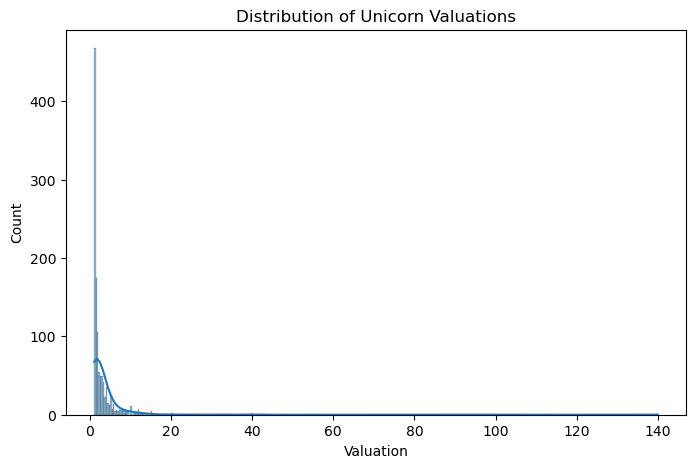

In [8]:
# Distribution of Valuations
plt.figure(figsize=(8,5))
sns.histplot(df['Valuation'], kde=True)
plt.title("Distribution of Unicorn Valuations")
plt.show()

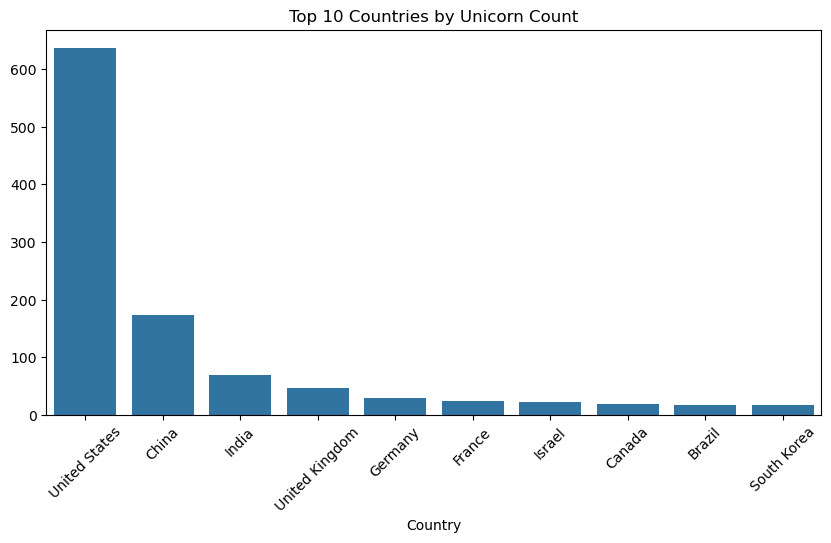

In [9]:
# Top countries producing unicorns
top_countries = df['Country'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title("Top 10 Countries by Unicorn Count")
plt.xticks(rotation=45)
plt.show()

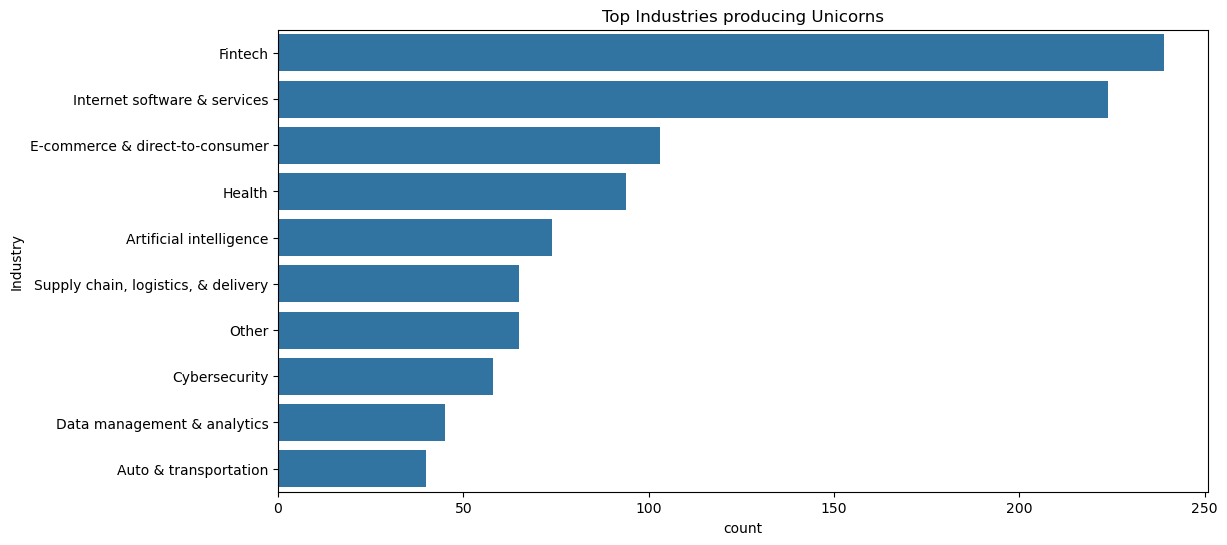

In [10]:
# Industry distribution
plt.figure(figsize=(12,6))
sns.countplot(y=df['Industry'], order=df['Industry'].value_counts().index[:10])
plt.title("Top Industries producing Unicorns")
plt.show()

# 7.Feature Engineering

In [11]:
# Feature: Age of Company since joining unicorn club
df['Age_since_Joined'] = 2022 - df['year']

# Number of Investors
df['Num_Investors'] = df[['Investor_1', 'Investor_2', 'Investor_3', 'Investor_4']].notnull().sum(axis=1)

# Encode categorical values 
df = pd.get_dummies(df, columns=['City\xa0'], drop_first = True)

print(df.shape)

(1186, 298)


# 8.Train-Test Split

In [12]:
# Define features ad target
X = df.drop(['Company', 'Date_Joined', 'Investor_1', 'Investor_2', 'Investor_3', 'Investor_4','Country','Industry'], axis=1)
y= df['Valuation']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 9.Model Training & Evaluation

In [13]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Linear Regression R^2:", r2_score(y_test, y_pred_lr))
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred_lr))

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest R^2:", r2_score(y_test, y_pred_rf))
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))

Linear Regression R^2: 0.9999967076994765
Linear Regression MSE: 2.8929710600030102e-05
Random Forest R^2: 0.9997324896175137
Random Forest MSE: 0.0023506353361344655


# 10.Model Tuning

In [14]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.960054152993523


#                                       Insights & Reporting

# 1. Countries Producing Most Unicorns

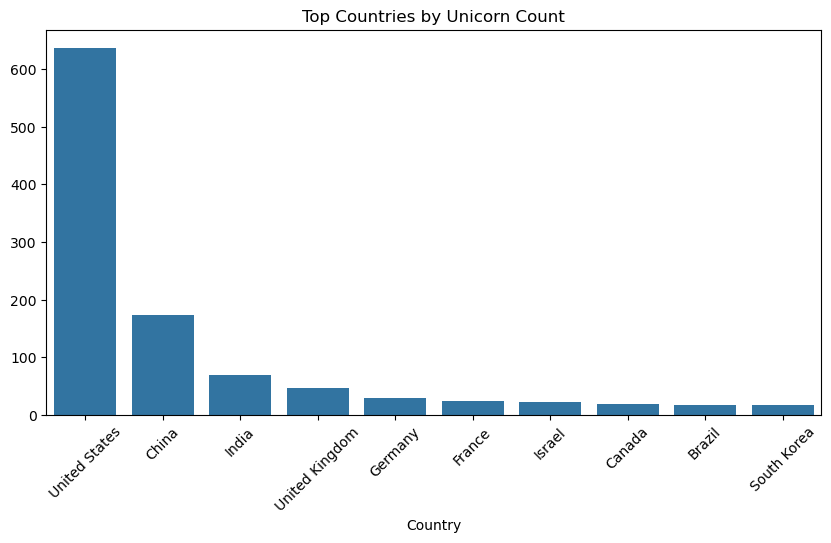

Country
United States     636
China             174
India              70
United Kingdom     46
Germany            29
France             24
Israel             22
Canada             19
Brazil             17
South Korea        17
Name: count, dtype: int64

In [15]:
top_countries = df['Country'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title("Top Countries by Unicorn Count")
plt.xticks(rotation=45)
plt.show()

top_countries

# 2. Industries with Highest Valuation

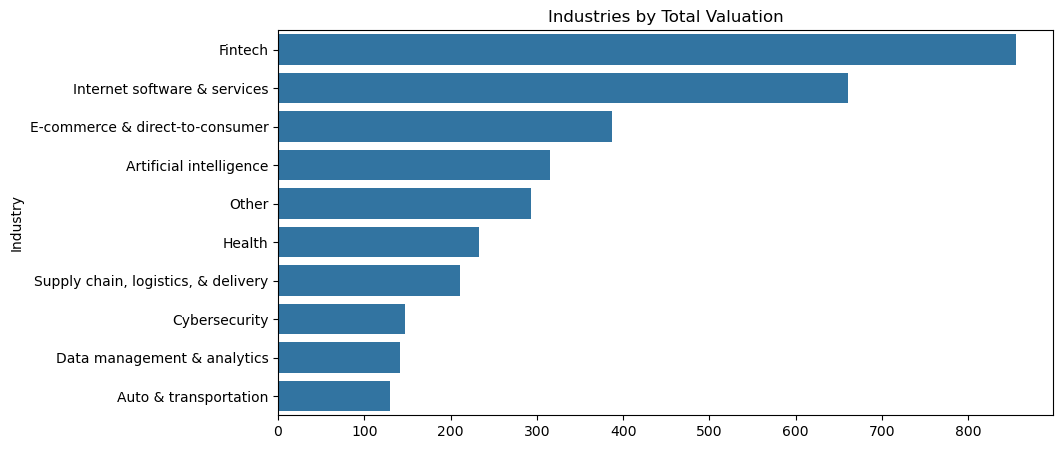

Industry
Fintech                                855.43
Internet software & services           660.93
E-commerce & direct-to-consumer        387.19
Artificial intelligence                315.01
Other                                  293.72
Health                                 233.16
Supply chain, logistics, & delivery    211.47
Cybersecurity                          147.00
Data management & analytics            141.79
Auto & transportation                  129.47
Name: Valuation, dtype: float64

In [16]:
industry_valuation = df.groupby('Industry')['Valuation'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=industry_valuation.values, y= industry_valuation.index)
plt.title("Industries by Total Valuation")
plt.show()

industry_valuation

# 3. Top Investors

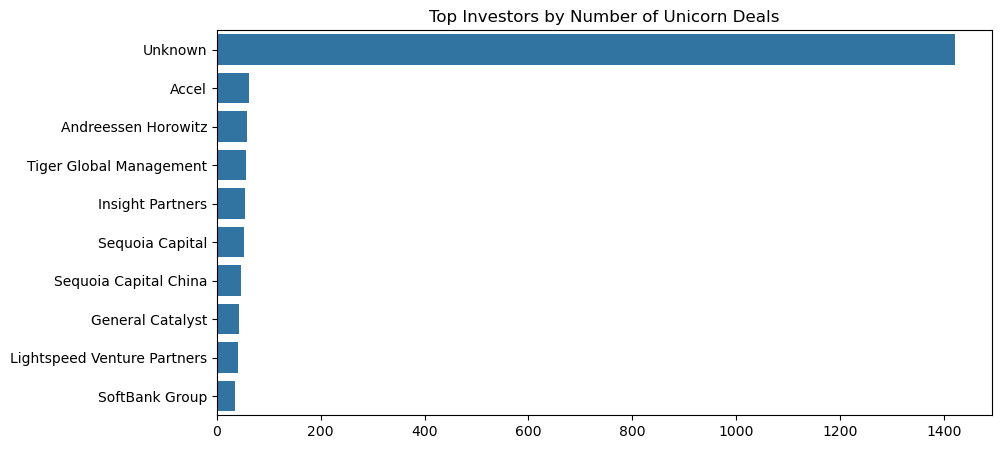

{'Unknown': 1421,
 'Accel': 62,
 'Andreessen Horowitz': 59,
 'Tiger Global Management': 56,
 'Insight Partners': 55,
 'Sequoia Capital': 52,
 'Sequoia Capital China': 46,
 'General Catalyst': 42,
 'Lightspeed Venture Partners': 40,
 'SoftBank Group': 35}

In [17]:
from collections import Counter
all_investors = df[['Investor_1', 'Investor_2', 'Investor_3', 'Investor_4']].fillna('').agg(','.join, axis=1).str.split(',').sum()
investor_counts = Counter([i.strip() for i in all_investors])
top_investors = dict(investor_counts.most_common(10))

plt.figure(figsize=(10,5))
sns.barplot(x=list(top_investors.values()), y= list(top_investors.keys()))
plt.title("Top Investors by Number of Unicorn Deals")
plt.show()

top_investors

# 4.Growth of Unicorns Over TIme

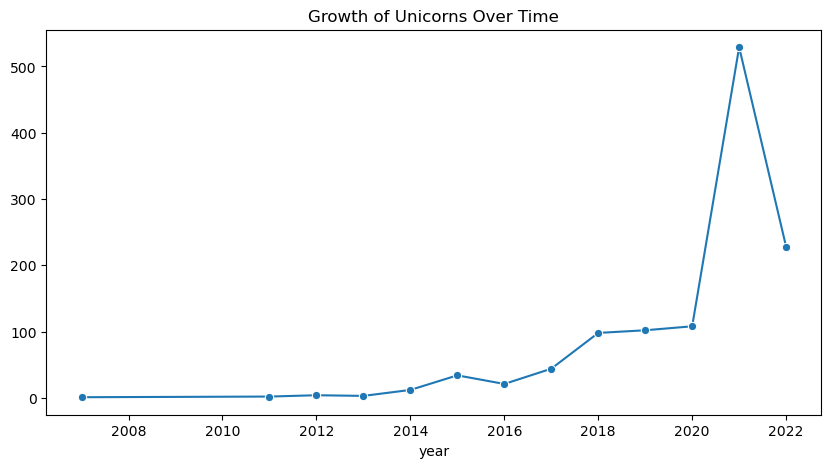

year
2007      1
2011      2
2012      4
2013      3
2014     12
2015     34
2016     21
2017     44
2018     98
2019    102
2020    108
2021    529
2022    228
dtype: int64

In [18]:
df['Date_Joined'] = pd.to_datetime(df['Date_Joined'])
df['year'] = df['Date_Joined'].dt.year

yearly = df.groupby('year').size()

plt.figure(figsize=(10,5))
sns.lineplot(x=yearly.index, y=yearly.values, marker="o")
plt.title("Growth of Unicorns Over Time")
plt.show()

yearly